# Assignment 1: k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [1]:
# Load required packages and dataset. Do not modify.
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()

## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


**Answer:**

The dataset consists of `150` samples of flowers. Each flower is described by the features `sepal length`, `sepal width`, `petal length`, and `petal width` and belongs to one of three species `Iris setosa`, `Iris virginica`, and `Iris versicolor`. The species is the classification target. All features are numerical.

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [2]:
class_names = ['setosa', 'versicolor', 'virginica']
feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

print(f'#samples: {X.shape[0]}')

for class_name, class_count in zip(class_names, np.bincount(y)):
    print(f'- class {class_name}: {class_count}')
print()
    
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
for feature_idx, feature_name in enumerate(feature_names):
    print(f'{feature_name}:')
    print(f'- mean: {mean[feature_idx]:.2f}')
    print(f'- std: {std[feature_idx]:.2f}')
    print()

#samples: 150
- class setosa: 50
- class versicolor: 50
- class virginica: 50

sepal length:
- mean: 5.84
- std: 0.83

sepal width:
- mean: 3.06
- std: 0.43

petal length:
- mean: 3.76
- std: 1.76

petal width:
- mean: 1.20
- std: 0.76



3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

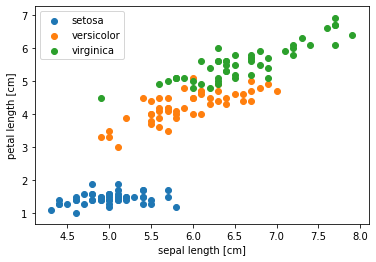

In [3]:
fig, ax = plt.subplots(1, 1)
for class_idx, class_name in enumerate(class_names):
    ax.scatter(X[y == class_idx, 0], X[y == class_idx, 2], label=class_name)
ax.set_xlabel('sepal length [cm]')
ax.set_ylabel('petal length [cm]')
ax.legend();

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [4]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    np.random.seed(2020)  # Ensure that the random split always returns the same result.
    
    threshold = int(0.7*X.shape[0])
    rnd_idx = np.random.permutation(X.shape[0])
    
    X_train = X[rnd_idx[:threshold]]
    X_test = X[rnd_idx[threshold:]]
    y_train = y[rnd_idx[:threshold]]
    y_test = y[rnd_idx[threshold:]]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]

5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [5]:
X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)

def min_max_scale(X):
    return (X - X_min) / (X_max - X_min)

X_train = min_max_scale(X_train)
X_test = min_max_scale(X_test)

## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [6]:
class KNearestNeighbors(object):
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y
    
    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,d), 
        where n is the number of samples and d is the number of features.
        """
        if self.distance_metric == 'uniform':
            dist = euclidean_distance
        else:
            dist = self.distance_metric
            
        # Compute pairwise distances between inputs and training samples.
        pw_distances = np.array([[dist(x1, x2) for x1 in X] for x2 in self.X])
        # Identify k nearest neighbors for each input sample.
        neighbors = np.argsort(pw_distances, axis=0)[:self.k].T
        
        labels = []
        for idx, nb in enumerate(neighbors):
            candidate_labels = np.unique(y_train[nb])
            candidate_weights = []

            for candidate in candidate_labels:
                if self.distance_metric == 'uniform': # uniform weights
                    candidate_weight = np.sum(self.y[nb] == candidate)
                else: # distance-weighted
                    weights = 1.0/pw_distances[nb, idx][self.y[nb] == candidate]
                    # If distance is 0, the corresponding weight will be infinity,
                    # which results in us just looking up the correct label or performing 1-NN.
                    candidate_weight = np.sum(weights)
                
                candidate_weights.append(candidate_weight)
            
            # Select the class label with highest weight.
            label_idx = np.argmax(candidate_weights)
            label = candidate_labels[label_idx]
            labels.append(label)
        
        return np.array(labels)

    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))


## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [7]:
def precision(y_pred, y_true):
    # We compute the macro-average
    labels = set(y_pred).union(set(y_true))
    precisions = list()
    for label in labels:
        tp, fp, _, _ = tp_fp_tn_fn(y_pred, y_true, label)
        if (tp + fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        precisions.append(prec)
    return np.mean(precisions)


def recall(y_pred, y_true):
    # We compute the macro-average
    labels = set(y_pred).union(set(y_true))
    recalls = list()
    for label in labels:
        tp, _, _, fn = tp_fp_tn_fn(y_pred, y_true, label)
        recalls.append(tp / (tp + fn))
    return np.mean(recalls)


def f1score(y_pred, y_true):
    # We compute the macro-average
    labels = set(y_pred).union(set(y_true))
    f1scores = list()
    for label in labels:
        tp, fp, _, fn = tp_fp_tn_fn(y_pred, y_true, label)
        if (tp + fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1scores.append(2 * (prec * rec) / (prec + rec))
    return np.mean(f1scores)


def tp_fp_tn_fn(y_pred, y_true, positive_label):
    # Count true positive, false positives, true negatives, false negatives for a specific class.
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for yp, yt in zip(y_pred, y_true):
        if yp == yt and yt == positive_label: # tp
            tp += 1
        elif yp != yt and yt == positive_label: # fp
            fp += 1
        elif yp == yt and yt != positive_label: # tn
            tn += 1
        else: # fn
            fn += 1
    return tp, fp, tn, fn
        

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

<ipython-input-6-2e8e6a091288>:37: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0/pw_distances[nb, idx][self.y[nb] == candidate]


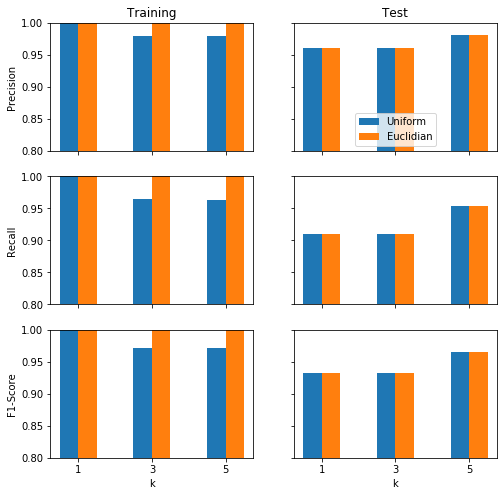

In [8]:
ks = (1, 3, 5)
metrics = ('uniform', 'euclidean')
hyperparameters = [(k, metric) for metric in metrics for k in ks]

scores = []
for k, metric in hyperparameters:
        classifier = KNearestNeighbors(
            k=k, 
            distance_metric='uniform' if metric == 'uniform' else euclidean_distance
        )
        classifier.fit(X_train, y_train)
        yhat_train = classifier.predict(X_train)
        yhat_test = classifier.predict(X_test)
                
        scores.append([
            [fnc(yhat, y) for fnc in (precision, recall, f1score)] 
            for yhat, y in ((yhat_train, y_train), (yhat_test, y_test))
        ])
        
scores = np.array(scores)
ks = np.array(ks)
fig, ax = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
for row in range(3):
    for col in range(2):
        ax[row, col].bar(ks-0.25, scores[:3, col, row], width=0.5, label='Uniform')
        ax[row, col].bar(ks+0.25, scores[3:, col, row], width=0.5, label='Euclidian')
        ax[row, col].set_ylim((0.8, 1.0))
        
ax[0, 0].set_ylabel('Precision')
ax[1, 0].set_ylabel('Recall')
ax[2, 0].set_ylabel('F1-Score')
ax[0, 0].set_title('Training')
ax[0, 1].set_title('Test')
ax[-1, 0].set_xlabel('k')
ax[-1, 1].set_xlabel('k')
ax[-1, 0].set_xticks(ks)
ax[0, 1].legend();

- distance-weighted kNN achieves perfect results on training data due to infinity-valued weights for training samples
- to identify the best classifier we have to look only at the test data
- 1-NN performs worst of all options
- the choice of weighting does not matter in this use case, but if the sample is known distance-weighting will provide correct results

3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

If a sample is already in the training data, 1-NN will look up this sample and return the corresponding class. Therefore it will always achieve perfect results on the training data. This behavior does not translate to unseen data, which is shown in the evaluation.